# 비지도학습 군집화 테스트

###  "사용 데이터 : 장르별 베스트셀러 리뷰 모음"

### 조건
    * 각각의 ISBN끼리 리뷰를 합쳐서 테스트
    * 형용사 : 길이가 1이상
    * topics : 5
    * 테스트 : 5

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

%matplotlib inline

import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import urllib

In [2]:
import konlpy
from konlpy.tag import Okt

In [3]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# 데이터 전처리

## 도서 리뷰 추가

In [4]:
import glob
import pandas as pd
from pandas.core.dtypes.missing import notnull
import nltk
from konlpy.tag import Okt
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import re
from gensim.models import Word2Vec
from pandas import DataFrame
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## <전처리>

In [5]:
def cleansing(text):
    # text = str(text)
    pattern = "([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+.[a-zA-Z0-9-.]+)"  # e-mail 주소 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "(http|ftp|https)://(?:[-\w.]|(?:\da-fA-F]{2}))+"  # url 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "([^ㄷㅋㅎㅜㅠ가-힣a-zA-Z0-9])+"  # 한글 자음, 모음 제거 - without 'ㄷ,ㅋ,ㅎ,ㅜ,ㅠ'
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "<[^>]*>"  # html tag 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "[\r|\n]"  # \r, \n 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = re.compile(r"\s+")  # 이중 space 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    return text

### ISBN을 기준으로 리뷰를 모은 뒤 재조합

## <토큰화>

#### 분류 테스트 

In [6]:
okt = Okt()

----

### 기존 데이터 가져오기

In [7]:
# 불러오기
import pickle

book_morphs_with_isbn_pos_non_stopword = []
with open('data/detail_bestbook_unit_isbn_with_isbn_pos_non_stopword.txt', 'rb') as lf:
    book_morphs_with_isbn_pos_non_stopword = pickle.load(lf)
    
print(book_morphs_with_isbn_pos_non_stopword[0])

[9788959752195, [('내', 'Noun'), ('가제', 'Noun'), ('일', 'Noun'), ('좋아하다', 'Adjective'), ('책', 'Noun'), ('이', 'Noun'), ('당', 'Noun'), ('6', 'Number')]]


In [8]:
print(len(book_morphs_with_isbn_pos_non_stopword))

print(book_morphs_with_isbn_pos_non_stopword[10])

42559
[9788974825515, [('아이', 'Noun'), ('에게', 'Josa'), ('중국어', 'Noun'), ('에', 'Josa'), ('대한', 'Noun'), ('자신감', 'Noun'), ('을', 'Josa'), ('실어', 'Noun'), ('줄', 'Noun'), ('수', 'Noun'), ('있다', 'Adjective'), ('책', 'Noun'), ('인', 'Noun'), ('것', 'Noun'), ('같다', 'Adjective'), ('열심히', 'Adverb'), ('공부', 'Noun'), ('하다', 'Verb'), ('자격증', 'Noun'), ('을', 'Josa'), ('따다', 'Verb'), ('중국어', 'Noun'), ('와', 'Verb'), ('더', 'Noun'), ('가깝다', 'Adjective'), ('지다', 'Noun'), ('하다', 'Verb')]]


In [9]:
print(book_morphs_with_isbn_pos_non_stopword[0])

[9788959752195, [('내', 'Noun'), ('가제', 'Noun'), ('일', 'Noun'), ('좋아하다', 'Adjective'), ('책', 'Noun'), ('이', 'Noun'), ('당', 'Noun'), ('6', 'Number')]]


In [10]:
#  도서 불용어를 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','것','라고','에게','라면','을','이라',
             '라니','있다','아','랑','쯤된','에서','에선','어','이지만','으로나','때','때는','때라면','때라서','라','이다','있','죠','고','니','로','있','같',
             '어서','어요','는데','습니다','면서','많이','마','더','그렇다','의','당','좀','책','안','볼','게','안','정말','듯','이제야','여','요','게다가','같다',
            '임','로서','이제','만','인','붙이','그','저','수','가제','부터','닷','저희','적','알','쉬','못','꼭','살','제','권','제','분','나','내', '진작', '전', '뿐'
            , '대한','대해','책','좋다','없다','아니다']

In [11]:
######### 태깅한 데이터 중에서 명사 + 형용사(1이상) + 불용어 처리

book_train_nouns_adj = []
book_train_isbn = []
for (isbn, test) in book_morphs_with_isbn_pos_non_stopword :
    tts = [(word,pos) for (word,pos) in test if not word in stopwords] #불용어 처리

    na = [word for (word,pos) in tts if pos in 'Noun'] # 명사만 저장
    for (word,pos) in tts : #형용사 : 길이가 1이상
        if pos == 'Adjective' and len(word)>1 :
            na.append(word)
    if na : 
        book_train_nouns_adj.append(na)
        book_train_isbn.append(isbn)

print('**********************END***************************')
print(len(book_train_nouns_adj))
print(len(book_train_isbn))

**********************END***************************
42463
42463


In [12]:
for i in range(0,5) :
#     print(book_morphs_with_isbn_pos_non_stopword[i])
    print(book_train_nouns_adj[i])

['일', '좋아하다']
['처음', '제목', '보고', '예상', '스토리', '완전', '신간', '홀린', '장바구니', '사서', '맘', '사서', '걸', '조금', '여자', '이야기', '다르다', '유쾌하다', '유치하다']
['덕분', '그릴', '별', '개', '사실', '정도', '채색', '채색', '별', '기대', '생각', '내용', '두고두고', '귀엽다', '기쁘다', '아쉽다', '알차다']
['구매', '쭉', '지리', '여행', '여행', '가기']
['요가', '궁극', '의미', '요가', '수행자', '위', '메시지', '방법', '과정', '자세', '설명', '알다', '정리', '매우', '서적', '요가', '공부', '위해', '구입', '공부', '도움', '요가', '교과서', '말', '요가', '백과사전', '식', '명작', '설명', '그림', '첨부', '재미', '실제', '응용', '위', '참고서', '아헹', '선생님', '요가', '알라딘', '쿠폰', '무료', '배송', '보아', '요가', '교과서', '최고', '요가', '입문', '무리', '유익하다', '어렵다', '자세하다', '훌륭하다']


----

# 정수 인코딩과 단어 집합 만들기

(인코딩값, 빈도수)

#### 데이터 셋
* 형용사 길이 > 1

In [13]:
from gensim import corpora


dictionary = corpora.Dictionary(book_train_nouns_adj)
corpus = [dictionary.doc2bow(text) for text in book_train_nouns_adj]

In [14]:
print(len(book_train_nouns_adj))
print(len(dictionary))
print(len(corpus))

42463
54347
42463


In [15]:
print(corpus[24983])

[(191, 1), (350, 1), (834, 1), (1612, 1)]


## 모델 평가 & 토픽 최적화

In [16]:
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel 
from gensim.models.callbacks import CoherenceMetric 
from gensim import corpora 
from gensim.models.callbacks import PerplexityMetric 

coherence_values=[]

for i in range(2,20) : 
    ldamodel = LdaModel(corpus,num_topics=i,id2word=dictionary)
    coherence_model_lda = CoherenceModel(model=ldamodel,texts=book_train_nouns_adj,dictionary=dictionary) # ,topn=10
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

In [17]:
print('coherence_values : ',coherence_values)

coherence_values :  [0.23408169616592497, 0.2869044036315523, 0.29170449935235065, 0.3023613826062373, 0.32708935737695327, 0.35593540841625865, 0.35445745457179045, 0.3507722891018578, 0.3404623249343007, 0.3310066401575977, 0.3659987942995278, 0.3313668974584366, 0.3633306883567214, 0.37354876832252765, 0.3456509794898094, 0.36524590359093456, 0.3388162584330512, 0.3666412502307455]


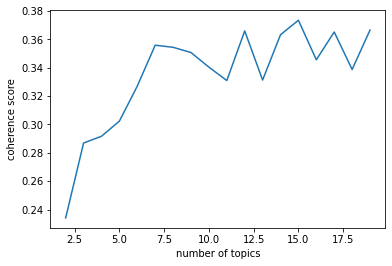

In [18]:
x=range(2,20,1)
plt.plot(x,coherence_values)
plt.xlabel('number of topics')
plt.ylabel('coherence score')
plt.show()

In [19]:
perplexity_values=[]

for i in range(2,20) :
    ldamodel = LdaModel(corpus,num_topics=i,id2word=dictionary)
    perplexity_values.append(ldamodel.log_perplexity(corpus))

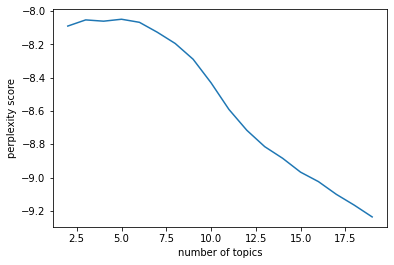

In [20]:
x=range(2,20)
plt.plot(x,perplexity_values)
plt.xlabel('number of topics')
plt.ylabel('perplexity score')
plt.show()

In [21]:
print('perplexity_values : ',perplexity_values)

perplexity_values :  [-8.089334920270208, -8.052344760443031, -8.060073656888672, -8.048411670320437, -8.06681686389115, -8.126459460200028, -8.193956605410177, -8.28849959505016, -8.429633191106424, -8.589673130890839, -8.714898519333367, -8.813219995391414, -8.882982679172402, -8.966150021043816, -9.023016854484569, -9.099461812870988, -9.164222475221415, -9.234885317032571]


#### (개인적인 생각 : 토픽 갯수를 생각할 때 coherence가 가장 높고 perplexity가 적당히 낮은 15개가 괜찮은 것 같다)

----

### Topics = 15 , Passes 테스트

In [23]:
coherence_values_passes=[]

for i in range(5,20) : 
    ldamodel = LdaModel(corpus,num_topics=15,id2word=dictionary,passes=i)
    coherence_model_lda = CoherenceModel(model=ldamodel,texts=book_train_nouns_adj,dictionary=dictionary) # ,topn=10
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values_passes.append(coherence_lda)

In [24]:
print('coherence_values_passes : ',coherence_values_passes)

coherence_values_passes :  [0.3980334030354479, 0.402322922663947, 0.3880773971327228, 0.3960466101843521, 0.36555950115900443, 0.39726480865847746, 0.39638948288841847, 0.38574006881568684, 0.39667144410223937, 0.39836939669248167, 0.3918873557766791, 0.36666445245963203, 0.39342294567538943, 0.39114197457432476, 0.37392379483538163]


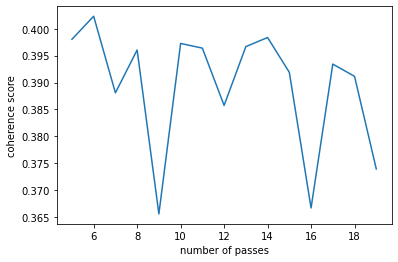

In [25]:
x=range(5,20)
plt.plot(x,coherence_values_passes)
plt.xlabel('number of passes')
plt.ylabel('coherence score')
plt.show()

#### (개인적인 생각 : passes는 6번 정도하는게 좋은 것 같다..)

----

### 토픽 선정 및 시각화

In [26]:
ldamodel = LdaModel(corpus,
                    num_topics=15,
                    id2word=dictionary,
                    passes=6) # 감마를 어떻게 할까.... alpha
topics = ldamodel.print_topics(num_words=8)
for topic in topics:
    print(topic)

(0, '0.035*"번역" + 0.017*"내용" + 0.010*"구매" + 0.009*"구입" + 0.008*"많다" + 0.008*"아쉽다" + 0.008*"다른" + 0.007*"가격"')
(1, '0.019*"사회" + 0.017*"생각" + 0.017*"미래" + 0.014*"우리" + 0.013*"인간" + 0.010*"철학" + 0.010*"어떻다" + 0.009*"고전"')
(2, '0.046*"그림" + 0.020*"마음" + 0.019*"예쁘다" + 0.017*"아름답다" + 0.015*"사진" + 0.012*"좋아하다" + 0.012*"곡" + 0.011*"시"')
(3, '0.028*"생각" + 0.020*"사람" + 0.018*"삶" + 0.012*"자신" + 0.012*"마음" + 0.012*"많다" + 0.011*"어떻다" + 0.010*"말"')
(4, '0.020*"글" + 0.018*"작가" + 0.016*"생각" + 0.015*"사람" + 0.013*"이야기" + 0.012*"말" + 0.012*"마음" + 0.007*"공감"')
(5, '0.040*"집" + 0.033*"도시" + 0.024*"스님" + 0.021*"건축" + 0.018*"공간" + 0.018*"술" + 0.017*"사장" + 0.015*"성경"')
(6, '0.019*"작품" + 0.019*"소설" + 0.018*"재밌다" + 0.016*"재미있다" + 0.016*"작가" + 0.015*"이야기" + 0.012*"기대" + 0.012*"영화"')
(7, '0.048*"공부" + 0.026*"영어" + 0.020*"문제" + 0.016*"교재" + 0.013*"단어" + 0.012*"도움" + 0.011*"학습" + 0.011*"수학"')
(8, '0.054*"독해" + 0.049*"문학" + 0.039*"대통령" + 0.031*"명상" + 0.031*"카드" + 0.029*"혁명" + 0.020*"실기" + 0.019*"암"')
(9, '0.022*"소설

In [27]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

In [28]:
for i, topic_list in enumerate(ldamodel[corpus]):
    if i==20:
        break
#     print(i,'번째 문서의 topic 비율은',topic_list)
    print(book_train_isbn[i],'의 topic 비율은',topic_list)

9788959752195 의 topic 비율은 [(0, 0.022222862), (1, 0.022222888), (2, 0.02222288), (3, 0.29184014), (4, 0.022222929), (5, 0.022222847), (6, 0.022222882), (7, 0.02222286), (8, 0.022222845), (9, 0.02222289), (10, 0.4192625), (11, 0.02222288), (12, 0.022222867), (13, 0.022222854), (14, 0.022222852)]
9791136202772 의 topic 비율은 [(6, 0.79322445), (11, 0.16342033)]
9791127420949 의 topic 비율은 [(0, 0.52868754), (2, 0.42315567)]
9791164383252 의 topic 비율은 [(11, 0.29517356), (14, 0.58100116)]
9788995797020 의 topic 비율은 [(0, 0.10797154), (1, 0.0437716), (5, 0.16583063), (7, 0.17818284), (12, 0.49186736)]
9788978495516 의 topic 비율은 [(0, 0.011157621), (1, 0.011157598), (2, 0.011157602), (3, 0.011157597), (4, 0.24065746), (5, 0.011157597), (6, 0.011157605), (7, 0.6142937), (8, 0.011157597), (9, 0.0111576), (10, 0.011157601), (11, 0.011157601), (12, 0.011157637), (13, 0.011157604), (14, 0.011157597)]
9788965912606 의 topic 비율은 [(1, 0.06507964), (10, 0.29614484), (12, 0.3413395), (13, 0.26075995)]
9788967354398

d:\project02\field-team4_test\machine_learning\web_scraping\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
# 모델 저장
model_name = 'model/nouns_adj_15topics_6passes'
ldamodel.save(model_name)

d:\project02\field-team4_test\machine_learning\web_scraping\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


9788955820072 의 topic 비율은 [(2, 0.3888356), (4, 0.32910487), (12, 0.2153306)]  
<세밀화로 보는 곤충의 생활>  
2 - 그림  
4 - 소설?  
12 - 정보성  
  
---  
  
국내도서 > 어린이 > 과학/수학/컴퓨터 > 생물과 생명  
국내도서 > 어린이 > 초등1~2학년 > 과학/수학/사회  
국내도서 > 유아 > 그림책 > 교양/학습 그림책  
국내도서 > 유아 > 그림책 > 그림백과/세밀화  
국내도서 > 유아 > 유아 교양/학습 > 유아 자연관찰/과학 > 동물   
국내도서 > 유아 > 유아 교양/학습 > 유아 학습 일반  
국내도서 > 추천도서 > 외부/전문기관 추천도서 > 고래가 숨쉬는 도서관 추천도서  

---

이 책의 가장 큰 장점은 '어울림'이다. 기존 곤충의 생태를 보여주는 책들이 마치 핀으로 고정한 듯한 곤충들의 나열이라면, 이 책은 푸근한 한국 농촌의 풍경 속에서 곤충들이 자연스럽게 녹아 있다. 들판에 꽃이 피고, 나뭇가지에 새순이 돋아나면, 꽃에는 벌과 나비가 모여든다.

자연 속에서 저마다 한살이를 보내는 한국의 곤충들을 봄, 여름, 가을, 겨울에 걸쳐 차근히 알려준다. 호랑나비, 암먹부전나비, 칠성무당벌레, 여치, 방아깨비, 철써기, 삽사리... 시골에서 어린 시절을 보낸 어른이라면 금방 머리에 떠오를 정겨운 벌레들이다. 얼마나 섬세하고 아름다운지 절로 탄성이 나온다.

나비와 벌은 꽃과 함께 있을 때 가장 아름답고, 나방은 여름밤과 가장 잘 어울린다. 물방개와 소금쟁이, 우묵날도래와 우렁이는 물풀이 하늘거리는 얕은 연못에 있어야 제 맛이다. 책 속에 나오는 다양한 곤충들은 저마다 가장 아름다운 모습으로 제일 잘 어울리는 장소 속에 등장한다.

큼직한 책 크기 속에 여름밤 전봇대의 전등 옆으로 날개를 펼치고 날아드는 벌레들, 숲 속 참나무에 붙어서 나무진을 빨아먹고 있는 풍뎅이들, 가을이 되어 짝짓기를 하는 잠자리. 그리고 겨울이 와 숲과 들판은 눈으로 덮히지만, 그 안에서도 벌레는 다음 해를 조용히 기다리고 있다.

한국의 아름다운 사계 속에서 살아가는 곤충들의 삶을 5년동안 묵묵히 취재하고 2년동안 쉴틈없이 세밀화로 옮긴 지은이의 노고에 감사드린다. 점점 사라져가고 있는 아름다운 자연과 그 속에서 자기만의 삶을 구축하며 살아가는 곤충들의 세계를 알려주는 것, 그것이 어른의 책임이 아닐까 한다.

In [ ]:
# (0, '0.035*"번역" + 0.017*"내용" + 0.010*"구매" + 0.009*"구입" + 0.008*"많다" + 0.008*"아쉽다" + 0.008*"다른" + 0.007*"가격"')
# (1, '0.019*"사회" + 0.017*"생각" + 0.017*"미래" + 0.014*"우리" + 0.013*"인간" + 0.010*"철학" + 0.010*"어떻다" + 0.009*"고전"')
# (2, '0.046*"그림" + 0.020*"마음" + 0.019*"예쁘다" + 0.017*"아름답다" + 0.015*"사진" + 0.012*"좋아하다" + 0.012*"곡" + 0.011*"시"')
# (3, '0.028*"생각" + 0.020*"사람" + 0.018*"삶" + 0.012*"자신" + 0.012*"마음" + 0.012*"많다" + 0.011*"어떻다" + 0.010*"말"')
# (4, '0.020*"글" + 0.018*"작가" + 0.016*"생각" + 0.015*"사람" + 0.013*"이야기" + 0.012*"말" + 0.012*"마음" + 0.007*"공감"')
# (5, '0.040*"집" + 0.033*"도시" + 0.024*"스님" + 0.021*"건축" + 0.018*"공간" + 0.018*"술" + 0.017*"사장" + 0.015*"성경"')
# (6, '0.019*"작품" + 0.019*"소설" + 0.018*"재밌다" + 0.016*"재미있다" + 0.016*"작가" + 0.015*"이야기" + 0.012*"기대" + 0.012*"영화"')
# (7, '0.048*"공부" + 0.026*"영어" + 0.020*"문제" + 0.016*"교재" + 0.013*"단어" + 0.012*"도움" + 0.011*"학습" + 0.011*"수학"')
# (8, '0.054*"독해" + 0.049*"문학" + 0.039*"대통령" + 0.031*"명상" + 0.031*"카드" + 0.029*"혁명" + 0.020*"실기" + 0.019*"암"')
# (9, '0.022*"소설" + 0.018*"이야기" + 0.013*"여성" + 0.012*"인간" + 0.011*"삶" + 0.011*"작품" + 0.009*"사랑" + 0.009*"작가"')
# (10, '0.107*"아이" + 0.028*"좋아하다" + 0.022*"재미있다" + 0.021*"엄마" + 0.018*"그림" + 0.013*"어른" + 0.013*"우리" + 0.012*"아들"')
# (11, '0.036*"구매" + 0.027*"기대" + 0.023*"요리" + 0.018*"음식" + 0.017*"보고" + 0.016*"레시피" + 0.013*"바로" + 0.013*"주문"')
# (12, '0.020*"도움" + 0.020*"내용" + 0.019*"설명" + 0.019*"많다" + 0.013*"알다" + 0.011*"추천" + 0.010*"이해" + 0.009*"사람"')
# (13, '0.046*"역사" + 0.024*"과학" + 0.015*"이해" + 0.015*"이야기" + 0.015*"재미있다" + 0.013*"흥미롭다" + 0.010*"어렵다" + 0.010*"알다"')
# (14, '0.112*"여행" + 0.060*"일본" + 0.028*"지도" + 0.021*"곳" + 0.017*"나라" + 0.015*"세계" + 0.014*"문화" + 0.012*"정보"')

---



9788974825515 의 topic 비율은 [(7, 0.7403959), (10, 0.100506864), (14, 0.08626847)]  
<뉴 어린이 중국어 능력시험 예상문제집 YCT 1급>  
  
7 - 학습   
10 - 아이와 관련된   
14 - 외국, 여행    

---  
국내도서 > 어린이 > 어린이 중국어  

---

중국어를 배우고 있는 어린이들이 중국어를 학습하고 복습하고 평가할 수 있는 종합적인 책. 각 급수에서 요구되는 기본적인 어휘를 전부 실었으며, 학생들의 이해력과 기억력 향상을 위해 모두 수준에 알맞은 예문을 들었다. 모의고사를 3회 수록하고, 학생들의 총 복습에 도움이 되고자 급수에 필요한 어휘, 문법, 언어 기능을 고루고루 다루었다.

